[English version](../index.ipynb)

In [1]:
#| code-fold: true

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm
import xarray as xr

random_seed = sum(map(ord, "cooling"))


def compute_temperature(time, r, T_0, T_env):
    return T_env + (T_0 - T_env) * np.exp(-r * time)


def plot_estimated_curves(idata, x, y, T_env, color="C0", kind="mean", axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    else:
        fig = axes[0].figure

    t_grid = np.linspace(0, 9, num=100)
    t_grid_xr = xr.DataArray(t_grid, coords={"__idx__": list(range(100))}, dims="__idx__")

    mu_transformed = idata.posterior["alpha"] - idata.posterior["beta"] * t_grid_xr

    if kind == "outcome":
        coords = mu_transformed.coords
        dims = mu_transformed.dims
        draws = np.random.normal(
            loc=mu_transformed, scale=idata.posterior["sigma"].to_numpy()[..., np.newaxis]
        )

        mu_transformed = xr.DataArray(
            draws,
            coords=coords,
            dims=dims
        )

    mu_original = np.exp(mu_transformed) + T_env
    mu_transformed_mean = mu_transformed.mean(("chain", "draw")).to_numpy()
    mu_transformed_ci50 = mu_transformed.quantile((0.25, 0.75), ("chain", "draw")).to_numpy()
    mu_transformed_ci90 = mu_transformed.quantile((0.05, 0.95), ("chain", "draw")).to_numpy()

    mu_original_mean = mu_original.mean(("chain", "draw")).to_numpy()
    mu_original_ci50 = mu_original.quantile((0.25, 0.75), ("chain", "draw")).to_numpy()
    mu_original_ci90 = mu_original.quantile((0.05, 0.95), ("chain", "draw")).to_numpy()


    axes[0].plot(t_grid, mu_original_mean, color=color)
    axes[0].fill_between(
        x=t_grid, y1=mu_original_ci50[0], y2=mu_original_ci50[1], alpha=0.5, color=color
    )
    axes[0].fill_between(
        x=t_grid, y1=mu_original_ci90[0], y2=mu_original_ci90[1], alpha=0.5, color=color
    )

    axes[1].plot(t_grid, mu_transformed_mean, color=color)
    axes[1].fill_between(
        x=t_grid, y1=mu_transformed_ci50[0], y2=mu_transformed_ci50[1], alpha=0.5, color=color
    )
    axes[1].fill_between(
        x=t_grid, y1=mu_transformed_ci90[0], y2=mu_transformed_ci90[1], alpha=0.5, color=color
    )

    axes[0].scatter(x, y, color="0.33");
    axes[1].scatter(x, np.log(y - T_env), color="0.33");

    axes[0].set(xlabel="Tiempo (horas)", ylabel="Temperatura (°C)");
    axes[1].set(xlabel="Tiempo (horas)", ylabel="$\\log(T - T_\\text{ambiente})$");

    axes[0].grid(ls="--")
    axes[1].grid(ls="--")
    axes[0].set_axisbelow(True)
    axes[1].set_axisbelow(True)

    return fig, axes

## Introducción

Hace algunas semanas, mientras navegaba por internet, me encontré con [este posteo](https://x.com/nicorioscenteno/status/1621655101164118017) en la red social X. Allí, un productor agropecuario comentaba un experimento que estaba a punto de realizar para medir la capacidad de retener calor que ofrecían varios termos que tenía a su disposición.

![](../imgs/posteo.png){width="500px"}

El experimento consistió en colocar agua a 80 °C en cada uno de los termos y registrar su temperatura varias veces durante el día.
Con los datos obtenidos, sería posible concluir sobre cuál termo ofrecía la mejor (y cuál la peor) capacidad de retener el calor.

Luego de varias mediciones, el autor del experimento [compartió](https://x.com/nicorioscenteno/status/1622039649622319104) los resultados obtenidos:

![](../imgs/posteo2.png){width="500px"}

De ellos se desprende que el termo "nn tapa rosa" fue el de peor desempeño, ya que el agua en su interior perdió calor considerablemente más rápidamente que en cualquier otro.

Ahora bien, la pregunta inevitable es: ¿cuál es el termo que ofrece una mejor retención de calor?

Para responder a esta incógnita usaremos un modelo Bayesiano basado en al Ley de enfriamiento de Newton.

## Ley de enfriamiento de Newton

La **ley de enfriamiento de Newton** dice que la temperatura de un objeto cambia a una velocidad proporcional a la diferencia entre su temperatura y la del ambiente:

$$
\frac{dT(t)}{dt} = r \, (T_\text{env} - T(t))
$$ {#eq-newton-cooling}

donde $r$ es una tasa de enfriamiento.

Una solución a la @eq-newton-cooling es:

$$
T(t) = T_\text{env} + (T(0)- T_\text{env}) \, e^{-rt}
$$ {#eq-newton-cooling-sol}

Esto significa que la temperatura presenta un decaimiento exponencial hacia la del ambiente conforme pasa el tiempo.

También se puede notar que el logaritmo de la diferencia entre la temperatura en un tiempo $t$ y la temperatura ambiente es una función lineal:

$$
\log\left(T(t) - T_\text{env}\right) = \log\left(T(0) - T_\text{env}\right) - rt
$$

que puede escribirse de manera más compacta como:

$$
\log\left(T(t) - T_\text{env}\right) = \alpha - \beta t
$$

donde $\alpha = \log\left(T(0) - T_\text{env}\right)$ y $\beta = r$.

La figura debajo muestra la forma que toma la @eq-newton-cooling-sol para diferentes tasas de enfriamiento $r$ junto a su correspondiente versión transformada.

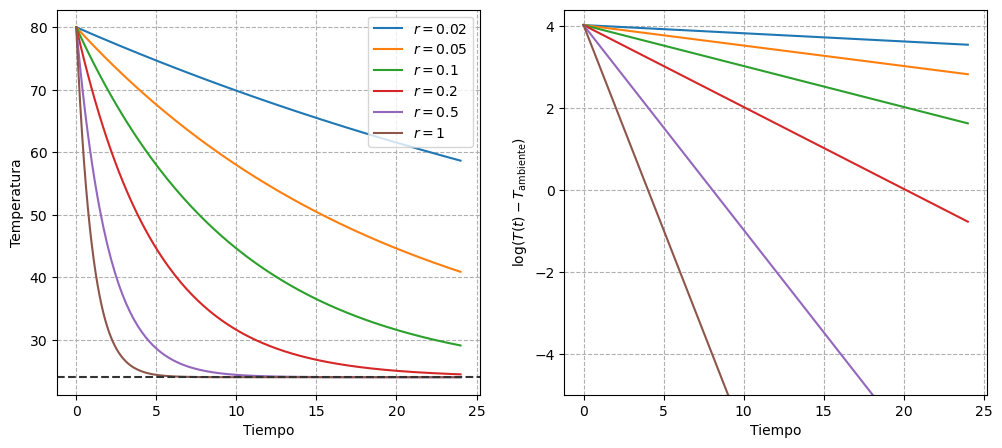

In [2]:
#| code-fold: true
#| label: fig-cooling
T_0, T_env = 80, 24
time_grid = np.linspace(0, 24, num=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for r in (0.02, 0.05, 0.1, 0.2, 0.5, 1):
    axes[0].plot(
        time_grid,
        compute_temperature(time=time_grid, r=r, T_0=T_0, T_env=T_env),
        label=f"$r={r}$"
    );
    axes[1].plot(
        time_grid,
        np.log(compute_temperature(time=time_grid, r=r, T_0=T_0, T_env=T_env) - T_env),
        label=f"$r={r}$"
    );

axes[0].axhline(y=T_env, color="0.2", lw=1.5, ls="--")
axes[0].grid(zorder=-99, ls="--")
axes[1].grid(zorder=-99, ls="--")
axes[1].set(ylim=(-5, 4.4))

axes[0].legend()
axes[0].set(xlabel="Tiempo", ylabel="Temperatura");
axes[1].set(xlabel="Tiempo", ylabel="$\\log(T(t) - T_\\text{ambiente})$");

Cuanto mayor sea el valor de $r$, peor será la capacidad del termo para retener temperatura. En otras palabras, el mejor termo será aquel con el valor de $r$ más bajo (asumiendo que $r > 0$).

## Elucidación de priors

En este artículo vamos a trabajar con modelos de la siguiente forma:

$$
\begin{aligned}
\log(T(t_i) - T_\text{env}) \mid t_i &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \alpha - \beta t_i
\end{aligned}
$$

Es decir, para un tiempo dado $t_i$, suponemos que el logaritmo de la diferencia entre la temperatura del agua y la temperatura ambiente sigue una distribución normal.

El parámetro de mayor interés es $\beta$, que representa la tasa de enfriamiento del agua en el termo. En primer lugar, sabemos que su valor debe ser positivo, ya que la temperatura del agua inicial desciende hasta la temperatura ambiente. Además, a partir de las curvas mostradas en la @fig-cooling, podemos suponer que un rango razonable para este parámetro se encuentra en el intervalo $(0, 1)$. Este rango implica que el agua del termo alcanzaría la temperatura ambiente, como rápido, unas 5 horas después de haberlo llenado.

Usando [PreliZ](https://preliz.readthedocs.io/en/latest/) se puede obtener los parámetros de una distribución gamma que satisfagan nuestros requisitos.

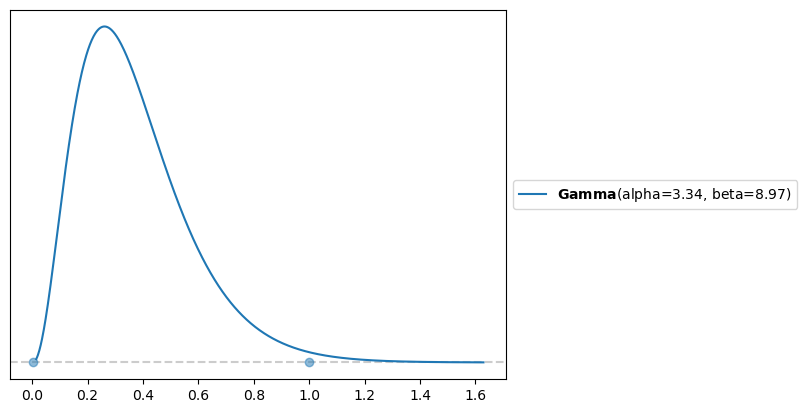

In [3]:
pz.maxent(pz.Gamma(), lower=0.001, upper=1, mass=0.99);

Otro parámetro desconocido en nuestro modelo es $\sigma$, el desvío estándar condicional.
Es importante destacar que este desvío no está expresado en grados centígrados, ya que describe la variabilidad de $\log(T(t_i) - T_\text{env})$, y no a la variablidad de $T(t_i)$.

Al observar el panel derecho de la @fig-cooling, se puede notar que el rango de variación de la respuesta cubre apenas unas pocas unidades. Por eso, en este caso vamos a optar por una distribución gamma moderadamente informativa, que concentre una alta probabilidad en el intervalo $(0.05, 0.3)$.

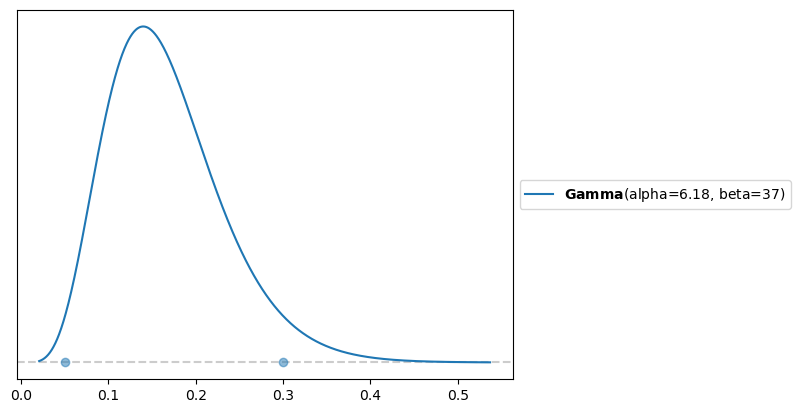

In [4]:
pz.maxent(pz.Gamma(), lower=0.05, upper=0.3, mass=0.95);

Finalmente, podríamos elucidar una distribución _a priori_ para $\alpha$. Sin embargo, no es un parámetro con una interpretación intuitiva.

Lo que sí podemos hacer es establecer un _prior_ para la temperatura inicial, que de manera implícita determine un _prior_ para $\alpha$.

Dado que en nuestro caso conocemos la temperatura del agua en $t = 0$, consideraremos dos enfoques:

* **Valor fijo** para $T(0)$: en este caso, $\alpha$ queda fijado a $\log(T(0) - T_\text{env})$.
* **Distribución informativa** para $T(0)$: centrada en el valor observado. Usamos una distribución normal con media $T(0)$ y desvío estándar de $0.3$ °C, lo que equivale a expresar que la temperatura inicial difiere, como máximo, en un grado de la temperatura medida.

## Datos

A partir de la foto compartida en el posteo de X, se pueden obtener los siguientes valores de tiempos y temperaturas:

In [5]:
T_env = 24
time = np.array([0, 180, 320, 500]) / 60 # en horas
data = {
    "stanley": np.array([80.0, 70.0, 65.0, 60.0]),
    "aluminio": np.array([80.0, 62.5, 57.5, 50.0]),
    "lumilagro": np.array([75.0, 65.0, 60.0, 55.0]),
    "nn-rosa": np.array([80.0, 47.5, 37.5, 30.0])
}

Cabe destacar que el valor de la temperatura ambiente (`T_env`) es un supuesto, ya que no aparece en ninguno de los posteos.

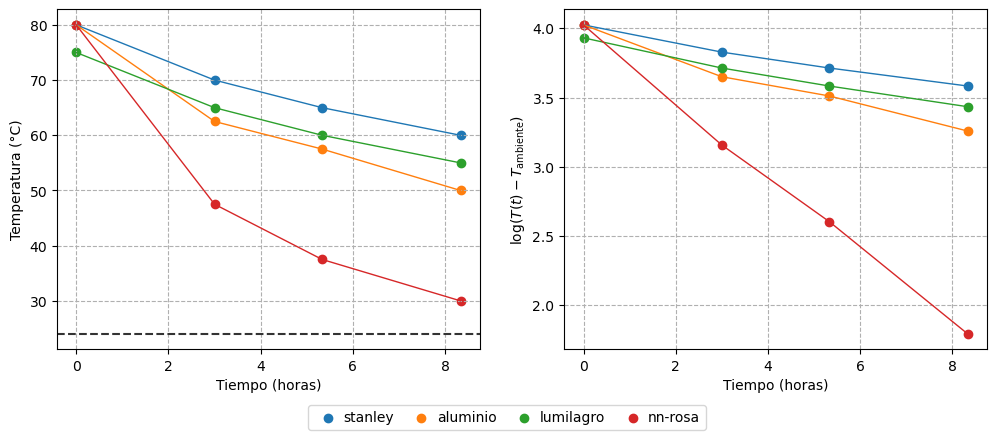

In [6]:
#| code-fold: true}
#| label: fig-data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(bottom=0.2)

for i, (brand, temperatures) in enumerate(data.items()):
    axes[0].plot(time, temperatures, color=f"C{i}", lw=1)
    axes[1].plot(time, np.log(temperatures - T_env), color=f"C{i}", lw=1)
    axes[0].scatter(time, temperatures, color=f"C{i}", label=brand)
    axes[1].scatter(time, np.log(temperatures - T_env), color=f"C{i}", label=brand)

axes[0].set(xlabel="Tiempo (horas)", ylabel="Temperatura (°C)");
axes[1].set(xlabel="Tiempo (horas)", ylabel="$\\log(T(t) - T_\\text{ambiente})$");
axes[0].grid(ls="--")
axes[1].grid(ls="--")

axes[0].axhline(y=T_env, color="0.2", lw=1.5, ls="--")

axes[1].legend(
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, 0.025),
    bbox_transform=fig.transFigure,
    handletextpad=0.1,
    columnspacing=1
);

A simple vista, el termo Stanley mantiene las temperaturas más altas en todo momento, mientras que el de tapa rosa destaca por su pobre desempeño.
El Lumilagro, por su parte, muestra un rendimiento superior al de aluminio: aunque comenzó con una temperatura inicial más baja, su enfriamiento fue más lento.
Por último, no puede afirmarse con certeza si el Stanley supera realmente al Lumilagro, ya que, si bien sus mediciones fueron siempre más altas, también partió con una temperatura mayor.

Por otra parte, el panel derecho de @fig-data muestra una tendencia lineal para cada termo, lo que es consistente con el uso de un modelo lineal sobre $\log(T(t) - T_\text{env})$.

## Modelos

### Modelo 1: Un termo + intercepto conocido

Antes de comenzar a trabajar con un modelo que considere a todas las marcas de termos, trabajemos con un modelo solo para la marca `"stanley"`.

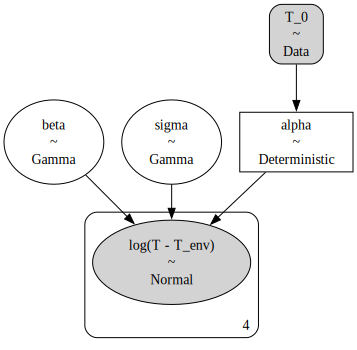

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [7]:
with pm.Model() as model_1:
    T_0 = pm.Data("T_0", data["stanley"].item(0)) # <1>
    alpha = pm.Deterministic("alpha", np.log(T_0 - T_env)) # <2>
    beta = pm.Gamma("beta", alpha=3.3, beta=9)
    sigma = pm.Gamma("sigma", alpha=6.2, beta=37)
    mu = alpha - beta * time
    pm.Normal("log(T - T_env)", mu=mu, sigma=sigma, observed=np.log(data["stanley"] - T_env))

display(model_1.to_graphviz())

with model_1:
    idata_1 = pm.sample(random_seed=random_seed, target_accept=0.95) # <3>

1. Se registra la temperatura inicial como dato dentro del modelo para que muestre el nodo correspondiente en el grafo.
2. Se registra `alpha` con `Deterministic` para que sus valores se almacenen en el grupo `posterior` de InferenceData.
3. Se utiliza siempre la misma semilla `random_seed` y un valor alto de `target_accept` para reducir la chance de divergencias.

A continuación, usamos `az.summary()` para obtener un resumen de los _posteriors_ marginales:

In [8]:
az.summary(idata_1, var_names=["beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.059,0.010,0.041,0.081,0.000,0.000,1421.0,1350.0,1.0
sigma,0.095,0.047,0.024,0.179,0.001,0.001,921.0,899.0,1.0


Para ambos parámetros, el tamaño efectivo de muestra es lo suficientemente grande, y las cadenas convergen y se mezclan correctamente. [^traceplots]

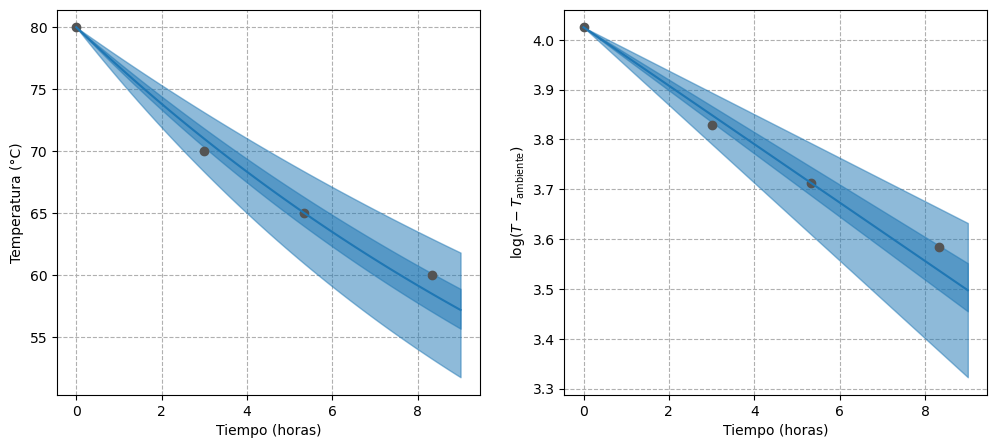

In [9]:
#| label: fig-posterior-summary-1
fig, axes = plot_estimated_curves(idata=idata_1, x=time, y=data["stanley"], T_env=T_env);

En el panel derecho de @fig-posterior-summary-1 se muestra la recta de regresión ajustada, junto con los intervalos de credibilidad del 50% y 95%, en la escala de datos transformada, mientras que en el panel izquierdo se muestran los resultados en la escala original. La recta de regresión se ajusta adecuadamente a los puntos, aunque la incertidumbre asociada a su estimación aumenta a medida que transcurre el tiempo. Por otro lado, la nula incertidumbre en $t=0$ se explica porque el intercepto tiene un valor fijo.

### Modelo 2: Un termo + intercepto desconocido

En este segundo modelo seguimos trabajando con un solo termo. La diferencia está en que, en vez de fijar la temperatura inicial al valor observado, le asignamos una distribución _a priori_ muy informativa. De esta forma, seguimos incorporando la información que ya conocemos, pero no forzamos a la recta de regresión a pasar por un punto fijo.

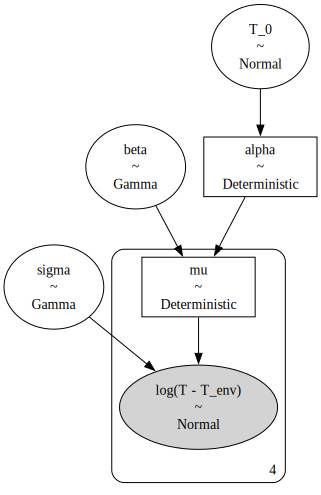

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T_0, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [10]:
with pm.Model() as model_2:
    T_0 = pm.Normal("T_0", mu=80, sigma=0.5)
    alpha = pm.Deterministic("alpha", np.log(T_0 - T_env))
    beta = pm.Gamma("beta", alpha=3.34, beta=12.8)
    sigma = pm.Gamma("sigma", alpha=6.2, beta=37)
    mu = pm.Deterministic("mu", alpha - beta * time)
    pm.Normal("log(T - T_env)", mu=mu, sigma=sigma, observed=np.log(data["stanley"] - T_env))

display(model_2.to_graphviz())

with model_2:
    idata_2 = pm.sample(random_seed=random_seed, target_accept=0.95)

In [11]:
az.summary(idata_2, var_names=["T_0", "alpha", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
T_0,79.993,0.508,79.056,80.967,0.010,0.009,2720.0,2448.0,1.0
alpha,4.025,0.009,4.008,4.042,0.000,0.000,2720.0,2448.0,1.0
beta,0.059,0.010,0.040,0.079,0.000,0.000,1891.0,1432.0,1.0
sigma,0.096,0.049,0.022,0.187,0.001,0.001,1399.0,1500.0,1.0


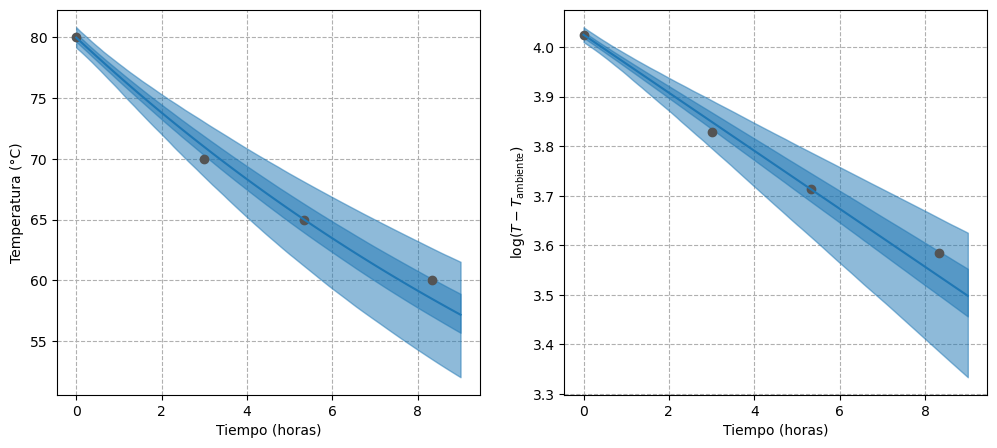

In [12]:
fig, axes = plot_estimated_curves(idata=idata_2, x=time, y=data["stanley"], T_env=T_env);

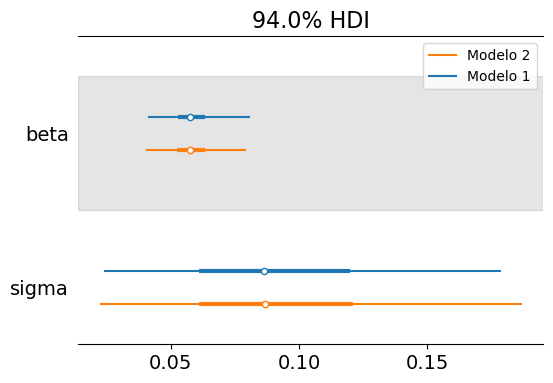

In [13]:
az.plot_forest([idata_1, idata_2], model_names=["Modelo 1", "Modelo 2"], var_names=["beta", "sigma"], combined=True, figsize=(6, 4));

Los _posteriors_ marginales de `beta` y `sigma` son prácticamente idénticos a los del primer modelo. En otras palabras, las conclusiones que se extraen sobre `beta` y `sigma` son similares a las que se obtienen cuando se usa una temperatura inicial fija. Además, los tamaños efectivos de muestra resultan siempre superiores a los obtenidos previamente.

### Modelo 3: Todas las marcas

Ahora que ya estamos familiarizados con el modelo para una sola marca, podemos extenderlo para trabajar con todas las marcas.

En lugar de tener un único `T_0`, `alpha` y `beta`, tendremos uno para cada marca. En PyMC, esto se logra usando `dims`, lo que nos permite trabajar con vectores de variables aleatorias en lugar de escalares.

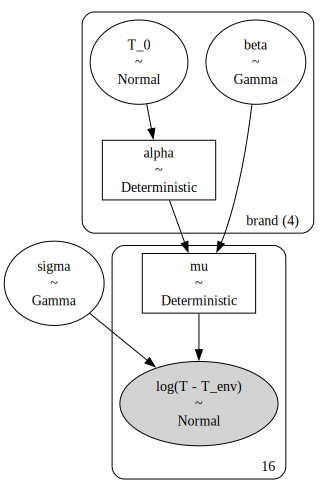

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T_0, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [14]:
y = np.log(np.concatenate([temps for temps in data.values()]) - T_env) # <1>
times = np.tile(time, 4)                                               # <1>
brand_idx = np.repeat(np.arange(4), 4)                                 # <1>
coords = {                                                             # <1>
    "brand": list(data)                                                # <1>
}                                                                      # <1>

with pm.Model(coords=coords) as model_3:
    T_0 = pm.Normal("T_0", mu=[v.item(0) for v in data.values()], sigma=0.5, dims="brand")
    alpha = pm.Deterministic("alpha", np.log(T_0 - T_env), dims="brand")
    beta = pm.Gamma("beta", alpha=3.3, beta=12.8, dims="brand")
    sigma = pm.Gamma("sigma", alpha=6.2, beta=37)
    mu = pm.Deterministic("mu", alpha[brand_idx] - beta[brand_idx] * times)
    pm.Normal("log(T - T_env)", mu=mu, sigma=sigma, observed=y)

display(model_3.to_graphviz())

with model_3:
    idata_3 = pm.sample(random_seed=random_seed, target_accept=0.95)

1. Se crean arreglos unidimensionales con las temperaturas, los tiempos y el índice de marca para todas las marcas. Además, se prepara un diccionario de coordenadas para poder usar `dims="brand"` en el modelo

Veamos el resumen _a posteriori_ que nos devuelve `az.summary()`.

In [15]:
az.summary(idata_3, var_names=["T_0", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
T_0[stanley],79.971,0.487,79.047,80.883,0.008,0.008,3452.0,2791.0,1.0
T_0[aluminio],79.895,0.493,79.028,80.855,0.008,0.008,3578.0,3149.0,1.0
T_0[lumilagro],74.971,0.483,74.097,75.889,0.008,0.007,4030.0,3046.0,1.0
T_0[nn-rosa],79.933,0.487,79.015,80.797,0.008,0.008,3840.0,3018.0,1.0
beta[stanley],0.056,0.005,0.047,0.067,0.000,0.000,2920.0,2203.0,1.0
beta[aluminio],0.096,0.005,0.086,0.105,0.000,0.000,2860.0,2534.0,1.0
beta[lumilagro],0.063,0.005,0.053,0.073,0.000,0.000,3685.0,2653.0,1.0
beta[nn-rosa],0.269,0.005,0.259,0.278,0.000,0.000,3425.0,2750.0,1.0
sigma,0.050,0.014,0.028,0.075,0.000,0.000,2049.0,2109.0,1.0


Lo primero que llama la atención es que las medias _a posteriori_ de las temperaturas iniciales se dividen en dos grupos: uno con valores cercanos a 80 y otro en torno a 75. Este resultado tiene sentido, ya que la temperatura inicial fue de 80 °C para todos los termos, excepto para el Lumilagro, que fue de 75 °C.

Por su parte, los `beta` para cada termo también muestran cierta heterogeneidad. En este caso, es posible concluir que el termo "nn-rosa" es el que presenta la mayor pérdida de calor (mayor valor de `beta`), aunque no es posible determinar con certeza cuál de ellos ofrece la mejor capacidad de retener de temperatura.

Finalmente, observamos que los tamaños efectivos de muestra oscilan entre 2000 y 4000, superando en todos los casos a los obtenidos en los modelos previos. Esto sugiere que el _posterior_ presenta una geometría más accesible para el _sampler_ NUTS que utiliza PyMC.

Si usamos la función `az.plot_forest()` podemos obtener un resumen de la distribución marginal de `beta` para cada marca:

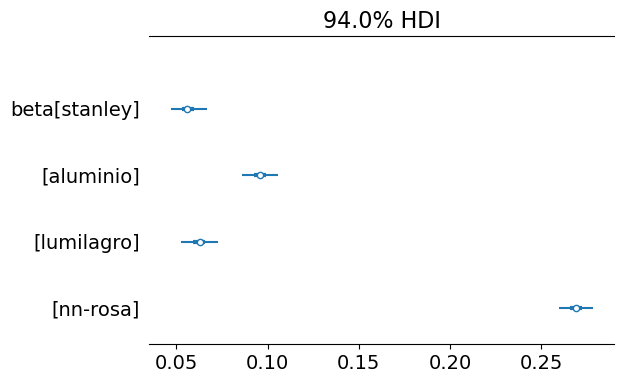

In [16]:
az.plot_forest(idata_3, var_names="beta", combined=True, figsize=(6, 4));

Como se mencionó anteriormente, el "nn-rosa" presenta la mayor pérdida de calor, seguido por el termo "aluminio", y finalmente los termos "lumilagro" y "stanley". A simple vista, podría parecer que el "stanley" tiene una mejor capacidad para conservar la temperatura, aunque este gráfico por sí solo no permite sacar conclusiones certeras.

Si bien el parámetro `sigma` no es relevante en sí mismo, resulta interesante explorar su distribución _a posteriori_, ya que ofrece una medida de la incertidumbre aleatoria alrededor de nuestra recta de regresión.

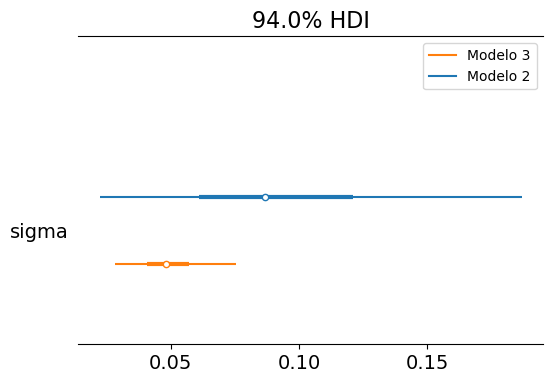

In [17]:
az.plot_forest(
    [idata_2, idata_3],
    model_names=["Modelo 2", "Modelo 3"],
    var_names="sigma",
    combined=True,
    figsize=(6, 4)
);

Al utilizar los datos de todos los termos en este tercer modelo, se obtiene una estimación de `sigma` con una incertidumbre considerablemente menor.

Finalmente, podemos visualizar las curvas estimadas para cada termos, tanto en su escala original como en la transformada:

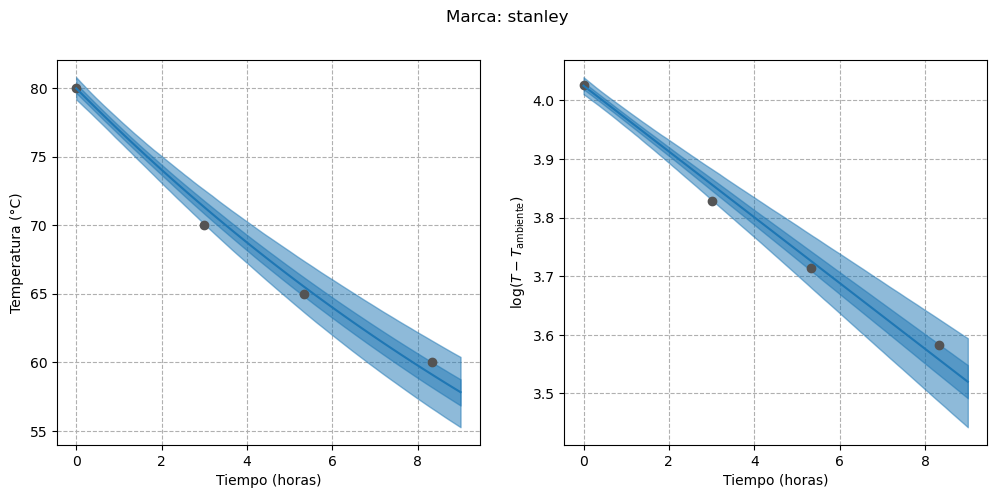

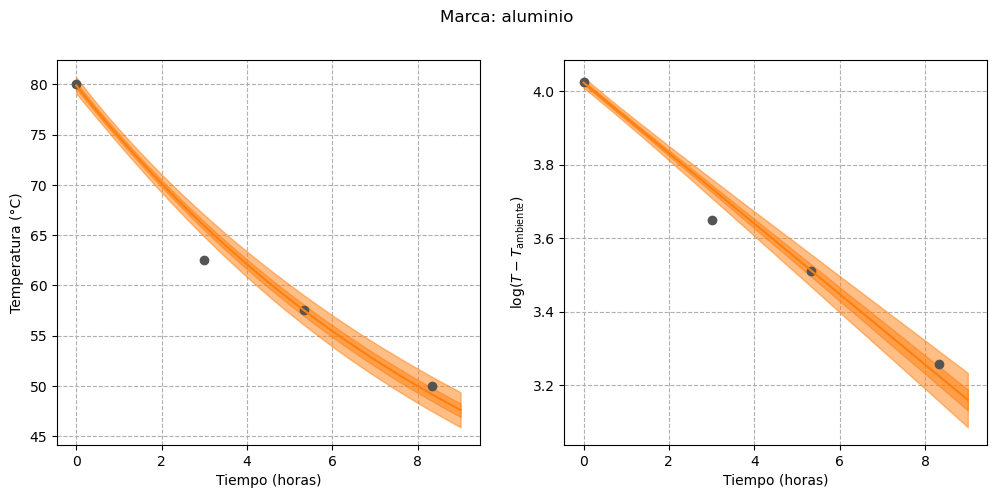

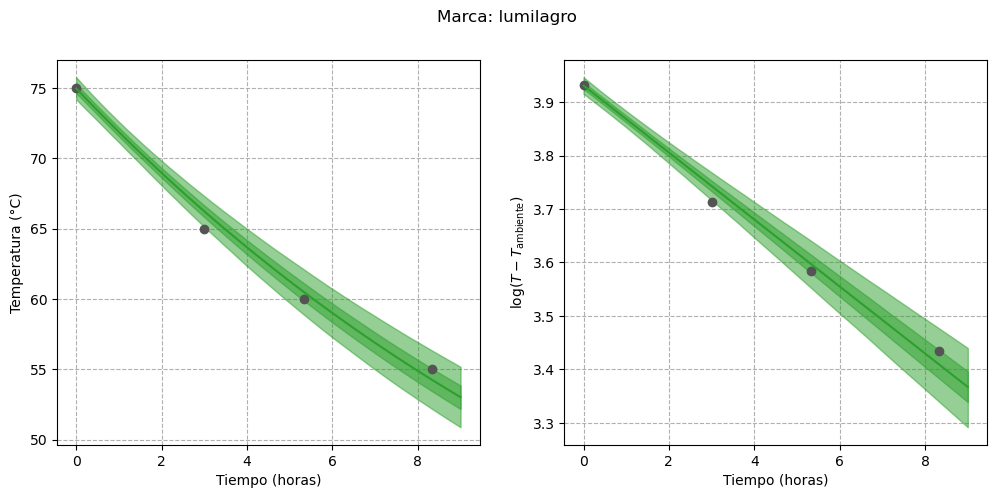

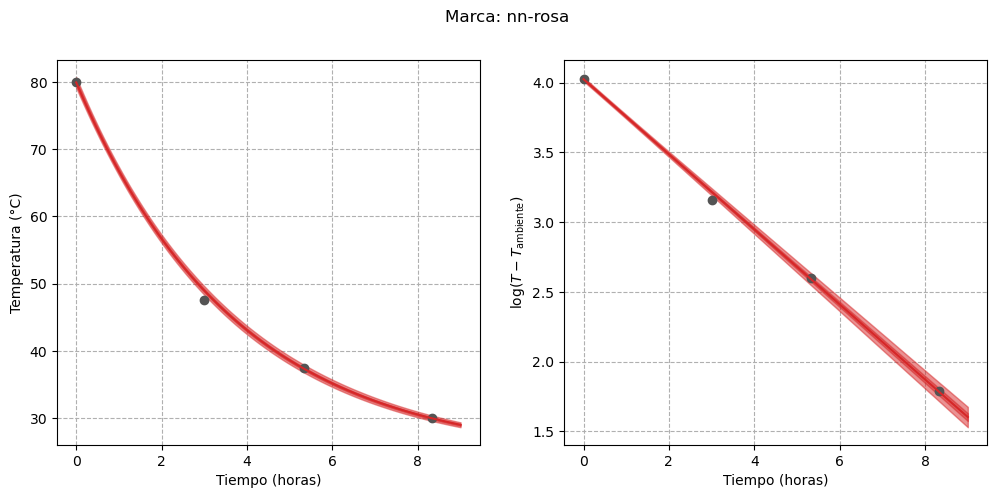

In [18]:
for i, brand in enumerate(data):
    fig, axes = plot_estimated_curves(
        idata=idata_3.sel(brand=brand),
        x=time,
        y=data[brand],
        T_env=T_env,
        color=f"C{i}",
    )
    fig.suptitle(f"Marca: {brand}")

En primer lugar, podemos notar que la incertidumbre en la recta de regresión para la marca "stanley" se redujo. Además, parece que en aquellos termos cuya temperatura del agua se acercó más rápidamente a la temperatura ambiente (es decir, los de menor capacidad para retener el calor) la incertidumbre es menor. El ejemplo más claro de este comportamiento es el termo "nn-rosa", cuya temperatura prácticamente igualó a la del ambiente hacia el final del experimento.

### Modelo 4: Todas las marcas + _partial pooling_ para $\beta$

Para finalizar, vamos a crear un modelo jerárquico donde asumimos que las tasas de enfriamiento $\beta$ pertenecen a una población común.
De este modo, al compartir información entre los termos, esperamos obtener _posteriors_ más precisos y estables, reflejando tanto las características individuales de cada termo como la tendencia general de la población.

In [19]:
with pm.Model(coords=coords) as model_4:
    T_0 = pm.Normal("T_0", mu=[v.item(0) for v in data.values()], sigma=0.5, dims="brand")
    alpha = pm.Deterministic("alpha", np.log(T_0 - T_env), dims="brand")

    beta_mu = pm.Normal("beta_mu", mu=3.3 / 12.8, sigma=0.05)                # <1>
    beta_sigma = pm.InverseGamma("beta_sigma", alpha=4.2, beta=0.3)          # <2>
    beta = pm.Gamma(                                                         # <1>
        "beta",                                                              # <1>
        alpha=(beta_mu / beta_sigma)**2,                                     # <1>
        beta=beta_mu / (beta_sigma**2),                                      # <1>
        dims="brand"                                                         # <1>
    )                                                                        # <1>

    sigma = pm.Gamma("sigma", alpha=6.2, beta=37)
    mu = pm.Deterministic("mu", alpha[brand_idx] - beta[brand_idx] * times)
    pm.Normal("log(T - T_env)", mu=mu, sigma=sigma, observed=y)


with model_4:
    idata_4 = pm.sample_prior_predictive(draws=1000, random_seed=random_seed) # <3>
    idata_4.extend(pm.sample(random_seed=random_seed, target_accept=0.95))

Sampling: [T_0, beta, beta_mu, beta_sigma, log(T - T_env), sigma]
Initializing NUTS using jitter+adapt_diag...
/home/tomas/miniconda3/envs/pymc-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T_0, beta_mu, beta_sigma, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


1. Los `beta` siguen teniendo un _prior_ gamma con media y desvío común. Pero en este caso estos parámetros son desconocidos y determinados por los datos.
2. Se utilizó `pz.maxent(pz.InverseGamma(), lower=0.01, upper=0.2, mass=0.95)`.
3. Se obtienen muestras del _prior_ para generar la @fig-prior-posterior.

Debajo se presentan los _posteriors_ marginales de $\beta$ y $\sigma$ para ambos modelos, el no jerárquico y el jerárquico:

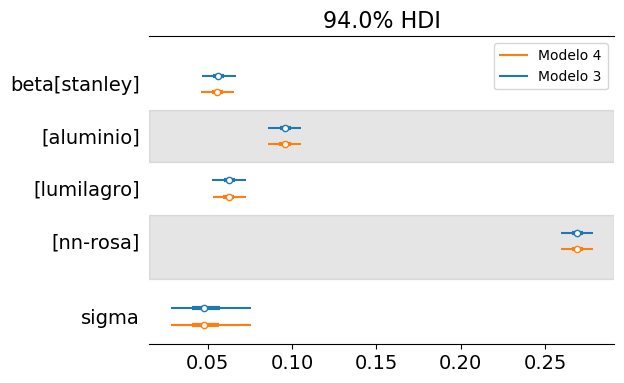

In [20]:
az.plot_forest(
    [idata_3, idata_4],
    model_names=["Modelo 3", "Modelo 4"],
    var_names=["beta", "sigma"],
    combined=True,
    figsize=(6, 4)
);

Visualmente, se puede concluir que no hay diferencias entre los _posteriors_ marginales de ambos modelos. En otras palabras, el _partial pooling_ que ofrece el modelo jerárquico es prácticamente inexistente.

Para entender por qué no se observan diferencias entre los modelos, podemos examinar el _prior_ y el _posterior_ de la media y el desvío poblacional de $\beta$ (`beta_mu` y `beta_sigma`).

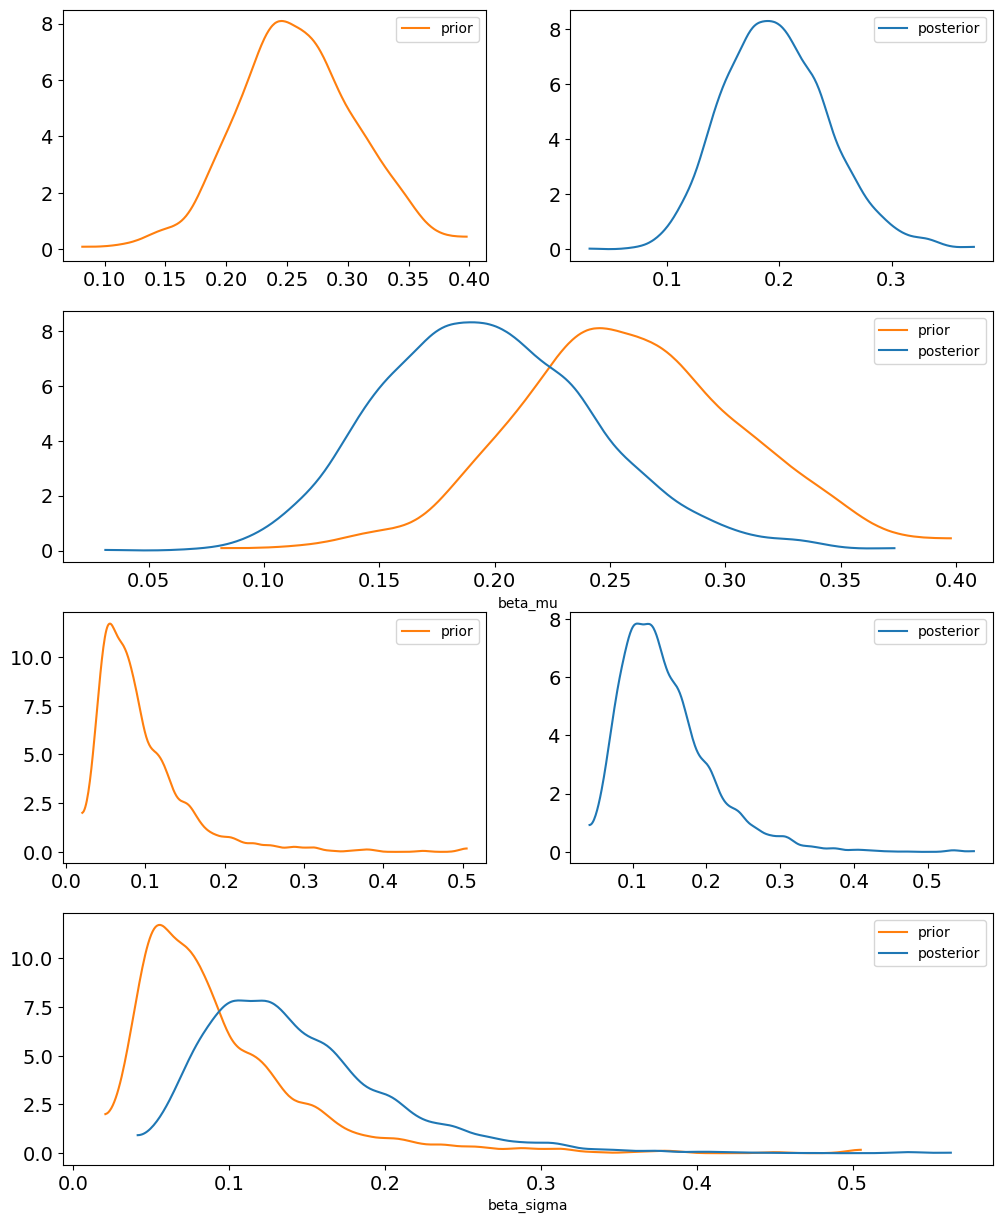

In [21]:
#| label: fig-prior-posterior
az.plot_dist_comparison(idata_4, var_names=["beta_mu", "beta_sigma"], figsize=(12, 15));

En ambos casos, el _posterior_ es muy similar al _prior_. Esto se debe a que la información disponible para estimar `beta_mu` y `beta_sigma` es insuficiente para obtener _posteriors_ con baja incertidumbre.
Este resultado es esperable, ya que el número de grupos es muy bajo (solo 4).
En situaciones así, salvo que se disponga de abundante información _a priori_, el enfoque jerárquico no ofrecerá diferencias apreciables respecto a un modelo con parámetros independientes.

## Conclusiones

### ¿Cuál es el mejor termo?

El mejor termo es aquel que presenta la menor tasa de enfriamiento $\beta$.

En base a nuestro modelo, podemos obtener un resultado probabilístico de la siguiente manera:

$$
P(\beta_j = \min\left\{\beta_1, \beta_2, \beta_3, \beta_4 \right\} ) \qquad \forall j \in {1, 2, 3, 4}
$$

In [22]:
beta_argmin = idata_4.posterior["beta"].argmin(axis=-1)
p_min = [(beta_argmin == j).mean().item() for j in range(4)]
dict(zip(data, p_min))

{'stanley': 0.826, 'aluminio': 0.0, 'lumilagro': 0.174, 'nn-rosa': 0.0}

Según nuestro modelo, hay un 82% de probabilidad de que el termo de la marca Stanley sea el que mejor conserva la temperatura.

En la práctica, nos corresponde a nosotros evaluar si esa probabilidad es suficiente para concluir que "stanley" es efectivamente superior a "lumilagro".
Por ejemplo, podría considerarse también la diferencia en grados que "stanley" logra mantener por encima de "lumilagro" a medida que pasa el tiempo.

Aunque el resultado no sea tan sorprendente, también es posible determinar de manera probabilística cuál es el peor de los termos:

$$
P(\beta_j = \max\left\{\beta_1, \beta_2, \beta_3, \beta_4 \right\} ) \qquad \forall j \in {1, 2, 3, 4}
$$

In [23]:
beta_argmax = idata_4.posterior["beta"].argmax(axis=-1)
p_max = [(beta_argmax == j).mean().item() for j in range(4)]
dict(zip(data, p_max))

{'stanley': 0.0, 'aluminio': 0.0, 'lumilagro': 0.0, 'nn-rosa': 1.0}

## Apéndice

### Inferencia en base a _priors_ uniformes

Tiene sentido preguntarse si el trabajo que conlleva la especificación de los _priors_ vale la pena.
Debajo, ajustamos el modelo multimarca utilizando _priors_ uniformes y comparamos los resultados con los obtenidos anteriormente.

In [24]:
with pm.Model(coords=coords) as model_5:
    alpha = pm.Flat("alpha", dims="brand")
    beta = pm.Flat("beta", dims="brand")
    sigma = pm.Uniform("sigma", lower=0, upper=100)
    mu = pm.Deterministic("mu", alpha[brand_idx] - beta[brand_idx] * times)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    idata_5 = pm.sample(random_seed=random_seed, target_accept=0.99, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


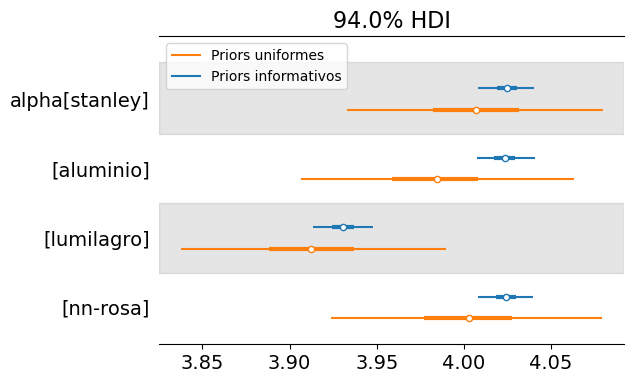

In [25]:
az.plot_forest(
    [idata_4, idata_5],
    model_names=["Priors informativos", "Priors uniformes"],
    var_names=["alpha"],
    combined=True,
    figsize=(6, 4)
);

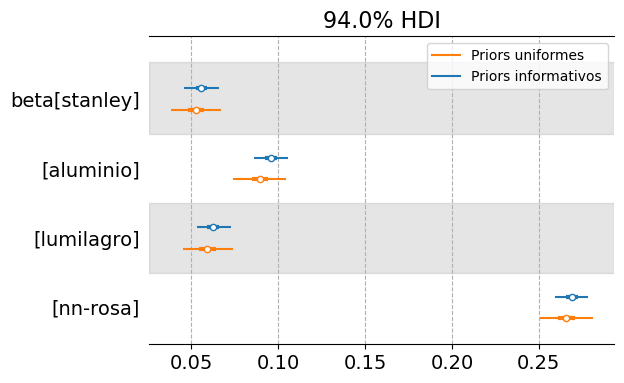

In [26]:
ax = az.plot_forest(
    [idata_4, idata_5],
    model_names=["Priors informativos", "Priors uniformes"],
    var_names=["beta"],
    combined=True,
    figsize=(6, 4)
)
ax[0].grid(axis="x", ls="--");

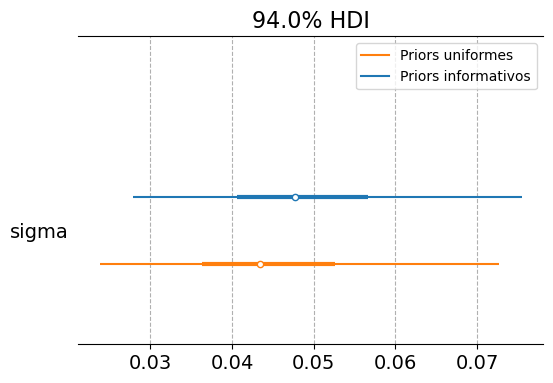

In [27]:
ax = az.plot_forest(
    [idata_4, idata_5],
    model_names=["Priors informativos", "Priors uniformes"],
    var_names=["sigma"],
    combined=True, figsize=(6, 4)
)
ax[0].grid(axis="x", ls="--");

In [28]:
beta_argmin = idata_5.posterior["beta"].argmin(axis=-1)
p_min = [(beta_argmin == j).mean().item() for j in range(4)]
dict(zip(data, p_min))

{'stanley': 0.74575, 'aluminio': 0.001, 'lumilagro': 0.25325, 'nn-rosa': 0.0}

In [29]:
beta_argmax = idata_5.posterior["beta"].argmax(axis=-1)
p_max = [(beta_argmax == j).mean().item() for j in range(4)]
dict(zip(data, p_max))

{'stanley': 0.0, 'aluminio': 0.0, 'lumilagro': 0.0, 'nn-rosa': 1.0}

En base a un modelo con _priors_ uniformes se extraen conclusiones en la misma dirección, pero con un nivel mayor de incertidumbre.

![Un agradable Thomas Bayes tomando mate](../imgs/thomas_bayes_mate.png){width="500px"}

[^traceplots]: En este blog no hacemos uso de los _traceplots_ porque las cadenas siempre se mezclan bien y resulta suficiente usar el tamaño efectivo de muestra y el $\hat{R}$.